In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
print("GPU Available:", torch.cuda.is_available())

print(torch.__version__)


GPU Available: False
2.4.1.post100


In [5]:
# Hyperparameters
batch_size = 64

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(8 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def _cnnForward(self,x):
        x = self.conv1(x)        
        x = self.pool(self.relu(x))
        return x
    
    def __Getsize_forFC(self):
        x = torch.rand((1, 1, 28, 28))
        with torch.no_grad():
            x = self._cnnForward(x)
        return x.reshape(-1,1).shape[0]
    
    def forward(self, x):
        x = self._cnnForward(x)
        x = x.view(-1, 8 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [7]:
# Train the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies


In [8]:
def evaluate_test_accuracy(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


In [9]:
model = CNN().to(device)

learning_rate = 0.001

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
num_epochs = 15
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/15], Train Loss: 0.3019, Train Accuracy: 91.66%, Val Loss: 0.1596, Val Accuracy: 95.14%
Epoch [2/15], Train Loss: 0.1062, Train Accuracy: 96.78%, Val Loss: 0.1092, Val Accuracy: 96.56%
Epoch [3/15], Train Loss: 0.0739, Train Accuracy: 97.74%, Val Loss: 0.0781, Val Accuracy: 97.58%
Epoch [4/15], Train Loss: 0.0540, Train Accuracy: 98.36%, Val Loss: 0.0635, Val Accuracy: 98.09%
Epoch [5/15], Train Loss: 0.0435, Train Accuracy: 98.70%, Val Loss: 0.0673, Val Accuracy: 98.00%
Epoch [6/15], Train Loss: 0.0353, Train Accuracy: 98.91%, Val Loss: 0.0630, Val Accuracy: 98.12%
Epoch [7/15], Train Loss: 0.0280, Train Accuracy: 99.14%, Val Loss: 0.0592, Val Accuracy: 98.18%
Epoch [8/15], Train Loss: 0.0233, Train Accuracy: 99.28%, Val Loss: 0.0654, Val Accuracy: 98.19%
Epoch [9/15], Train Loss: 0.0195, Train Accuracy: 99.37%, Val Loss: 0.0663, Val Accuracy: 98.18%
Epoch [10/15], Train Loss: 0.0164, Train Accuracy: 99.47%, Val Loss: 0.0703, Val Accuracy: 98.03%
Epoch [11/15], Train Loss: 0.

In [11]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 98.35%


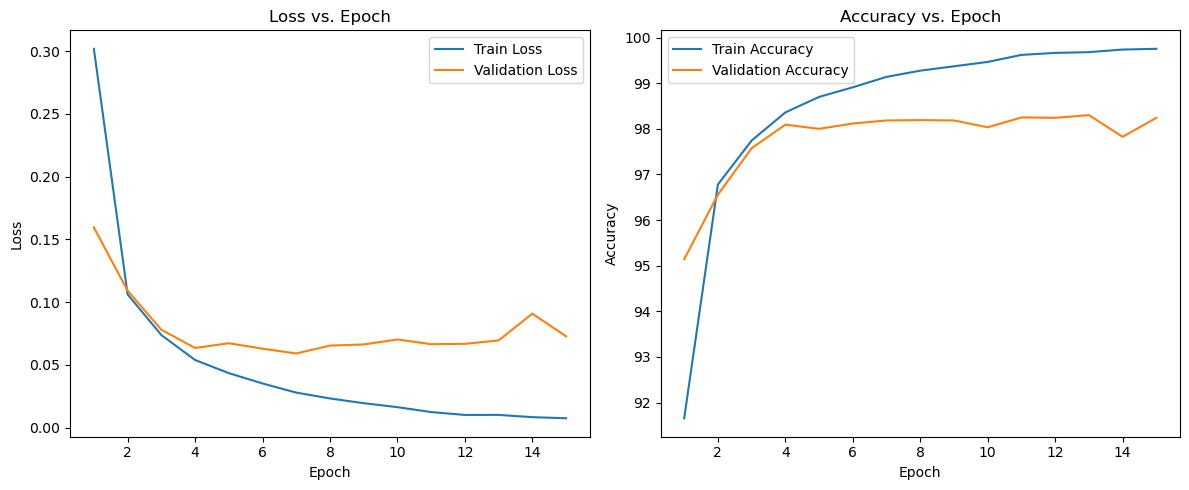

In [12]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## Practice

In [13]:
# Data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize each RGB channel
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# Define CNN model for CIFAR-10
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Adjusted for 3 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted for CIFAR-10 image size
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)  # Log-softmax for NLLLoss

### add BN layer

In [15]:
model = CIFAR10_CNN().to(device)

# Loss and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
num_epochs = 5

# Run training and save the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/5], Train Loss: 1.6179, Train Accuracy: 40.41%, Val Loss: 1.3546, Val Accuracy: 50.88%
Epoch [2/5], Train Loss: 1.2629, Train Accuracy: 54.39%, Val Loss: 1.1943, Val Accuracy: 57.46%
Epoch [3/5], Train Loss: 1.0785, Train Accuracy: 61.56%, Val Loss: 1.0008, Val Accuracy: 64.57%
Epoch [4/5], Train Loss: 0.9525, Train Accuracy: 66.12%, Val Loss: 0.9787, Val Accuracy: 64.92%
Epoch [5/5], Train Loss: 0.8710, Train Accuracy: 69.25%, Val Loss: 0.8626, Val Accuracy: 69.69%


In [17]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 69.59%


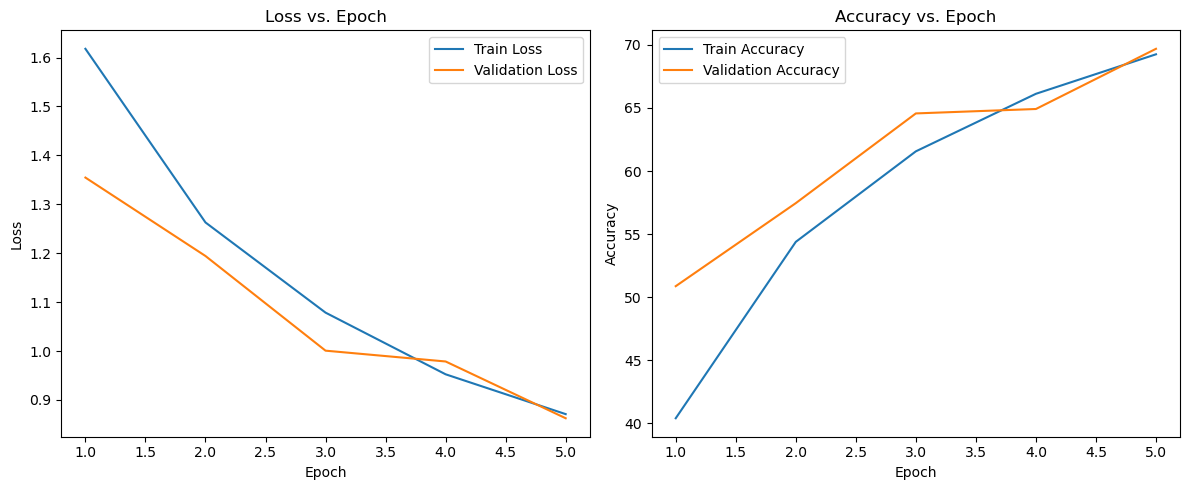

In [18]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Define CNN model for CIFAR-10
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Adjusted for 3 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)  # Adjusted for CIFAR-10 image size
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)  # Log-softmax for NLLLoss

In [20]:
model = CIFAR10_CNN().to(device)

# Loss and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
num_epochs = 5

# Run training and save the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/5], Train Loss: 1.6483, Train Accuracy: 38.04%, Val Loss: 1.3613, Val Accuracy: 49.55%
Epoch [2/5], Train Loss: 1.2371, Train Accuracy: 55.20%, Val Loss: 1.1518, Val Accuracy: 58.39%
Epoch [3/5], Train Loss: 1.0360, Train Accuracy: 63.13%, Val Loss: 0.9967, Val Accuracy: 63.80%
Epoch [4/5], Train Loss: 0.9207, Train Accuracy: 67.11%, Val Loss: 0.9035, Val Accuracy: 67.70%
Epoch [5/5], Train Loss: 0.8346, Train Accuracy: 70.56%, Val Loss: 0.8188, Val Accuracy: 70.64%


In [22]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 70.81%


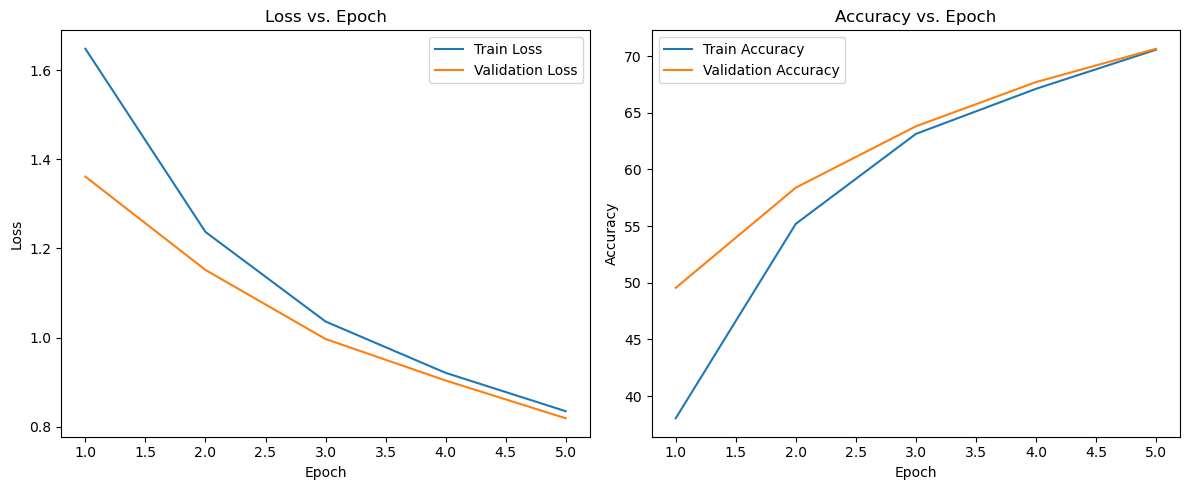

In [23]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

<div dir='rtl'>
با افزایش لایه هم دقت برای داده های تست و هم برای داده های یادگیری افزایش یافت
</div>